In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

# try hdbscan extraction
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

CPU times: user 11.2 s, sys: 406 ms, total: 11.6 s
Wall time: 9.31 s


In [2]:
def preprocess_clustering_data(X_train):
    X_train = X_train[X_train.index >= 0]


    to_drop = [
     'stcSAl',
     'ltkOri',
     'stbOri',
     'stcOri',
     'stbCeA',
    
    # #not in barcelona
     # 'ltcBuA', 
    #  'midRea',
    #  'midAre',
    #  'likWBB'

    #  'sdbPer', 
    #  'sdbCoA',
    #  'ssbCCM',
    #  'ltbIBD',
    #  'sdcLAL',
    #  'sdcAre',
    #  'sscERI',
    #  'mtcWNe',
    #  'mdcAre',
    #  'ltcWRB',
    #  'sicCAR',
    # "mtdDeg",


 #        'sdbPer',
 # 'sdbCoA',
 # 'ssbCCo',
 # 'ssbCor',
 # 'ssbERI',
 # 'ssbElo',
 # 'ltcBuA',
 # 'sdcAre',
 # 'stcSAl',


        # 'sdbCoA', 'ssbERI', 'mtdDeg', 'sscERI'
        
    ]
    
    all_drop = []
    for c in to_drop:
        all_drop += X_train.columns[X_train.columns.str.contains(c)].tolist()

    X_train = X_train.drop(all_drop, axis=1)
    
    vals = StandardScaler().fit_transform(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
    
    vals = np.nan_to_num(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
    
    stats = X_train.describe()
    X_train = X_train.drop(stats.columns[stats.loc['std'] == 0], axis=1)

    return X_train

def get_tree(training_data, clustering_graph, linkage, metric):

    clusterer = AgglomerativeClustering(linkage=linkage,
                                        connectivity = clustering_graph,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(training_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix

def get_clusters(linkage_matrix, min_cluster_size, eom_clusters=True):

    condensed_tree = condense_tree(linkage_matrix, 
                               min_cluster_size=min_cluster_size)
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

    if eom_clusters:
        selected_clusters = extract_eom_clusters(
            condensed_tree, cluster_tree, allow_single_cluster=False
        )
    else:
        selected_clusters = extract_leaves(
                condensed_tree, allow_single_cluster=False
            )
    return get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [3]:
def post_process_clusters(component_buildings_data, component_graph, component_clusters):


    component_clusters = component_clusters.copy()

    ## if all the poitns are noise try leaf clustering
    if (component_clusters == -1).all():
       component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=False)
        
    clrs, counts = np.unique(component_clusters, return_counts=True)
    
    ## assign each group of contiguous noise points to their own cluster
    if -1 in clrs:
        noise = component_buildings_data[component_clusters == -1].index.values
        noise_labels = component_graph.subgraph(noise).component_labels + max(clrs)
        component_clusters[component_clusters == -1] = noise_labels.values
    
    ## assign singletons to median of neighbours
    clrs, counts = np.unique(component_clusters, return_counts=True)
    for c in clrs[counts == 1]:
    
        bid = component_buildings_data.iloc[np.where(component_clusters == c)].index.values[0]
        median_cluster = np.median(component_clusters[np.where(component_buildings_data.index.isin(component_graph[bid].index))]).astype(int)
        component_clusters[component_clusters == c] = median_cluster

    return component_clusters

In [14]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [15]:
region_id = 'freiburg'
buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
chars_dir = '../data/freiburg/chars/'
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [16]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

spatial_lag = 3
lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')

lag = lag[[c for c in lag.columns if '_median' in c]]

# lag = lag.drop(lag.columns[(lag.columns.str.startswith('l')) | (lag.columns.str.startswith('m'))], axis=1)

X_train = X_train.join(lag, how='inner')

# X_train = lag

In [17]:
X_train.shape

(36181, 126)

In [18]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [19]:
min_cluster_size = 300
linkage = 'ward'
metric = 'euclidean'

In [20]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels


In [21]:
labels.value_counts()

component labels
3     34505
4       771
21      614
23       79
9        18
7        17
24       16
6         8
22        7
19        5
8         4
25        3
26        2
5         2
28        2
18        1
27        1
20        1
0         1
17        1
16        1
15        1
1         1
13        1
12        1
11        1
10        1
2         1
14        1
Name: count, dtype: int64

In [60]:
%%time

results = {}

for label, group in labels.groupby(labels):

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.ones(group.shape[0])

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values])
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)
        # component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=True)
        
        component_clusters = fcluster(ward_tree, t=80, criterion='distance')
        component_clusters = post_process_clusters(component_buildings_data, component_graph, component_clusters)

        for c in np.unique(component_clusters):
            cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
            assert cluster_graph.n_components == 1
    
        # if label ==3: break
    results[label] = component_clusters

CPU times: user 2.26 s, sys: 36.1 ms, total: 2.3 s
Wall time: 2.3 s


In [61]:
label_groups = labels.groupby(labels)
region_cluster_labels = []
for label, component_clusters in results.items():
    group = label_groups.get_group(label)
    component_labels = str(label) + '_' + pd.Series(component_clusters.astype(str), 
                                                    index=group.index.values)
    region_cluster_labels.append(component_labels)

region_cluster_labels = pd.concat(region_cluster_labels).sort_index()
assert (X_train[X_train.index >= 0].index == region_cluster_labels.index).all()
region_cluster_labels.to_csv(cluster_dir + f'clusters_{region_id}.csv')

In [62]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [63]:
labels.groupby(labels).size().sort_values(ascending=False)

component labels
3     34505
4       771
21      614
23       79
9        18
7        17
24       16
6         8
22        7
19        5
8         4
25        3
26        2
5         2
28        2
18        1
27        1
20        1
0         1
17        1
16        1
15        1
1         1
13        1
12        1
11        1
10        1
2         1
14        1
Name: component labels, dtype: int64

In [64]:
label = 3
labels.groupby(labels).get_group(label).shape

(34505,)

In [65]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [66]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [67]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values]
plotting['label'] = results[label]
plotting.shape

(34505, 3)

In [68]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [69]:
plotting['label'].nunique()

143

In [87]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 564 ms, sys: 47.7 ms, total: 612 ms
Wall time: 611 ms


In [88]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [54]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 23.8 s, sys: 179 μs, total: 23.8 s
Wall time: 23.8 s


In [55]:
# clrs_geometry.explore()

In [56]:
clrs_geometry.to_parquet(f'../data/clusters_{region_id}_{min_cluster_size}.pq')

----

In [74]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [75]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

In [76]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [77]:
component_data = component_data.groupby(results[label]).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

In [78]:
component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

UMAP(min_dist=0, n_neighbors=10, verbose=True)
Tue Aug 20 19:44:30 2024 Construct fuzzy simplicial set
Tue Aug 20 19:44:30 2024 Finding Nearest Neighbors
Tue Aug 20 19:44:30 2024 Finished Nearest Neighbor Search
Tue Aug 20 19:44:30 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Aug 20 19:44:31 2024 Finished embedding


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

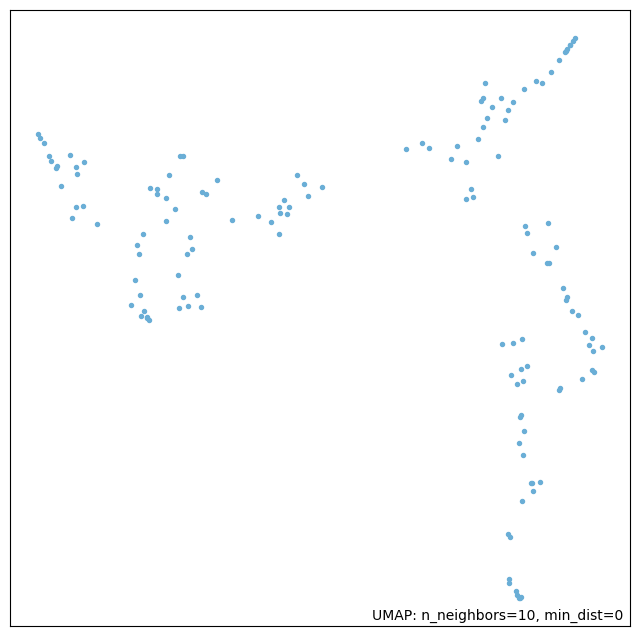

In [79]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='euclidean', verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
umap.plot.points(reducer)

In [90]:
clusterer = AgglomerativeClustering(linkage='ward',
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

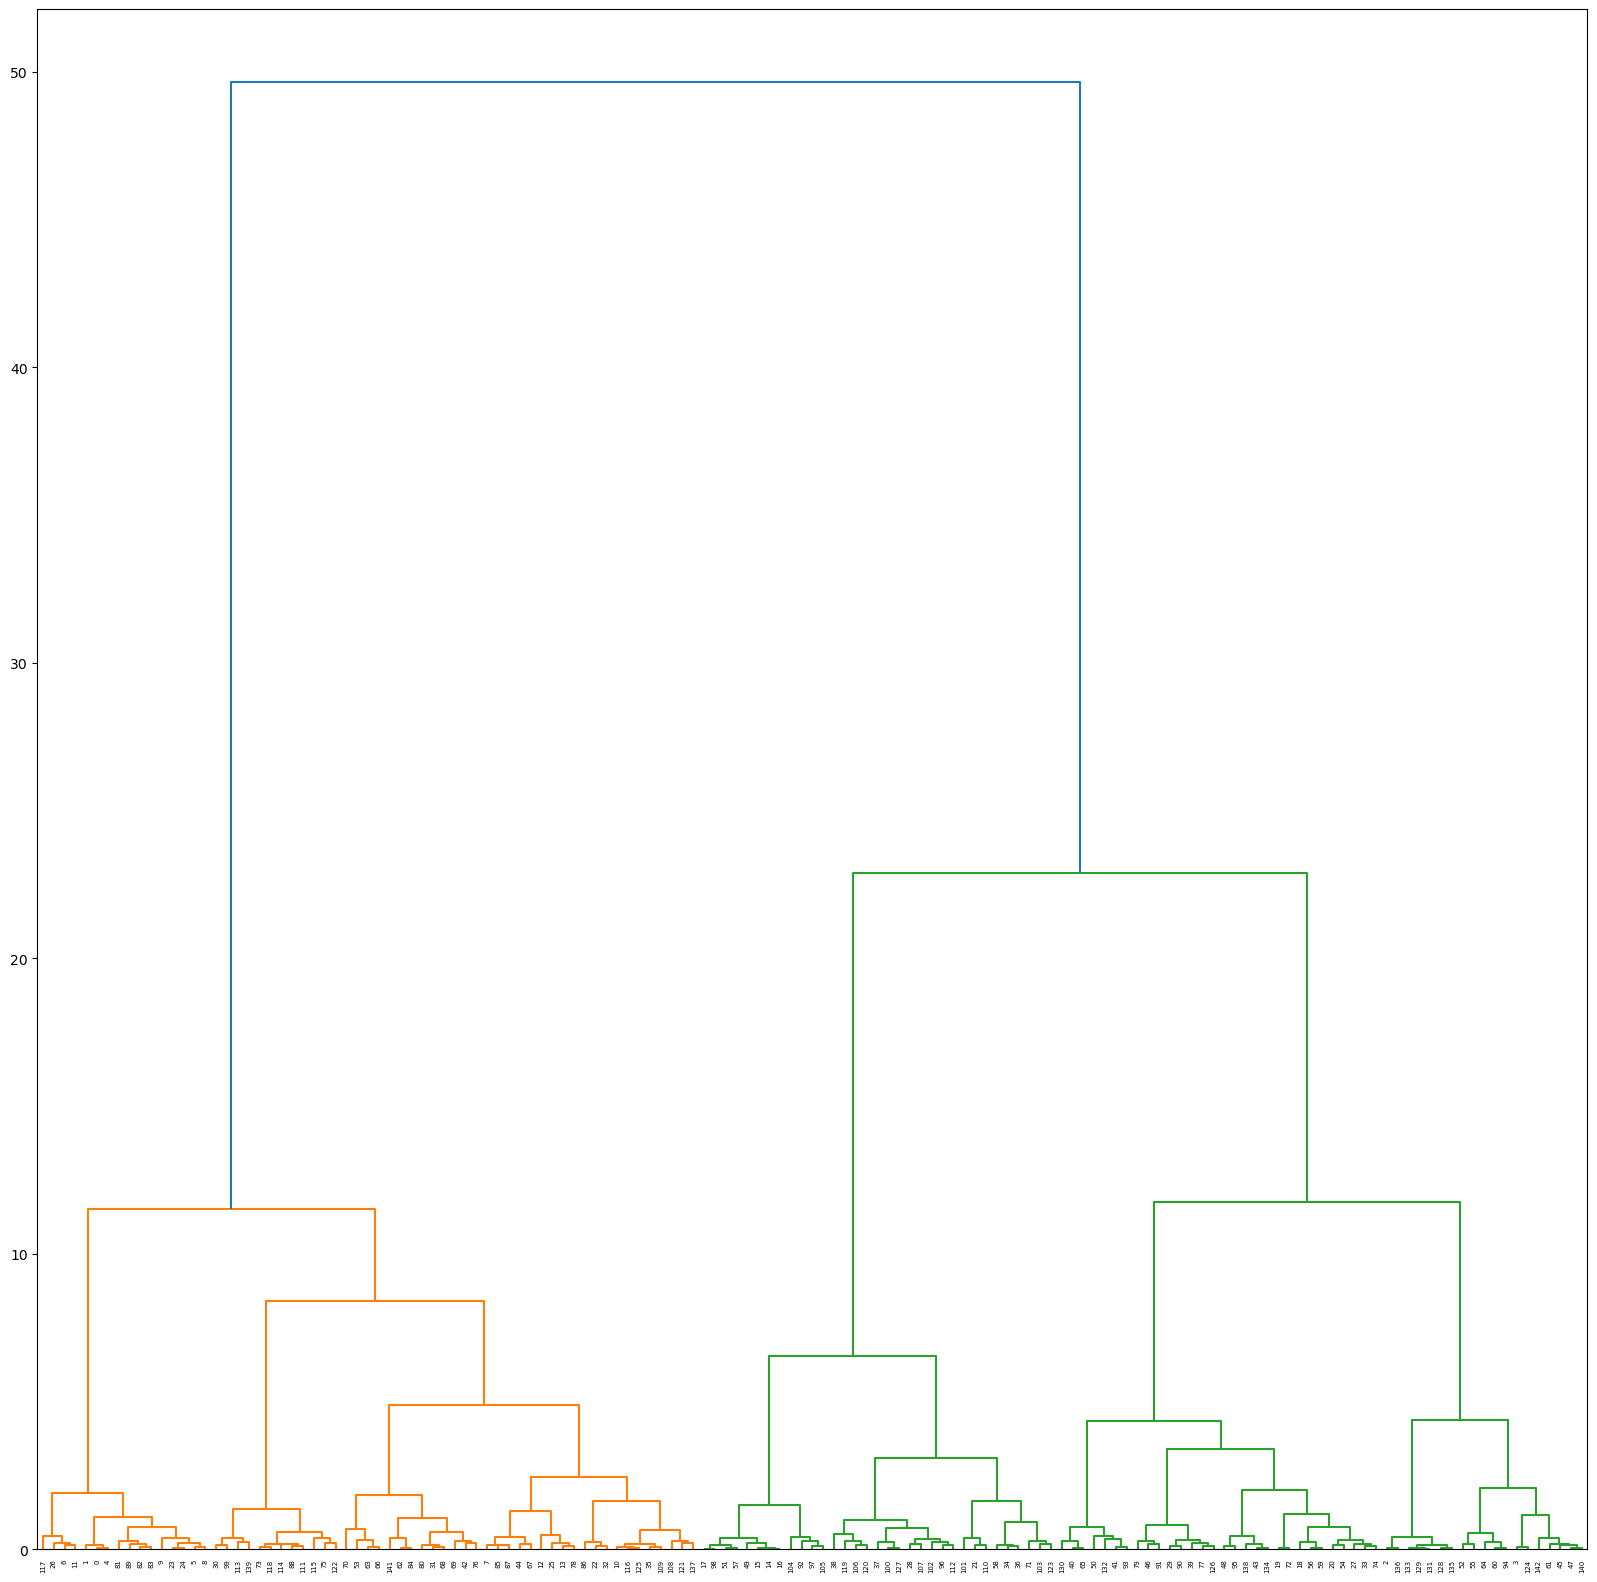

In [91]:
fig,ax = plt.subplots(figsize=(20,20))
_ = dendrogram(linkage_matrix, ax=ax)

In [92]:
clusters = fcluster(linkage_matrix, t=5, criterion='distance')

In [101]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
clusters = KMeans(n_clusters=15, max_iter=5000, n_init=100).fit(embedding).labels_

In [102]:
clusters

array([13, 13,  6,  6, 13, 13,  2, 12, 13,  2,  7,  2, 12, 12,  5,  5,  5,
        5,  8,  8,  8,  4,  7, 13, 13, 12,  2,  8, 14, 10,  9, 11,  7,  8,
        4,  7,  4, 14, 14, 10,  0,  0, 11,  0, 12,  3, 10,  3,  8,  5,  0,
        5,  3,  1,  8,  3,  8,  5,  4,  8,  3,  3, 11,  1,  3,  0,  1, 12,
       11, 11,  1,  4,  8,  9,  8,  9, 11, 10, 12, 10, 11, 13,  2,  2, 11,
       12, 11, 12,  9,  2, 10, 10,  5,  0,  3,  8, 14,  5,  5,  9, 14,  4,
       14,  4, 14,  5, 14, 14,  7,  7,  4,  9, 14,  9,  9,  9,  7,  2,  9,
       14, 14,  7,  9,  4,  6,  7, 10, 14,  6,  6,  0,  6,  0,  6,  0,  6,
        6,  7,  0,  9,  3, 11,  3], dtype=int32)

In [103]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters[-1] = -1
clusters = clusters.loc[results[label]].values

In [104]:
layer.get_fill_color = get_color(clusters)

In [146]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [150]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(60555, 63)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')